In [1]:
import gumbi as gmb
from gumbi.regression.botorch import GP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('future.no_silent_downcasting', True)

%config InlineBackend.figure_format = 'retina'

In [2]:
cars = sns.load_dataset('mpg').dropna().astype({'weight':float, 'model_year':float})

ds = gmb.DataSet(cars,
                 outputs=['mpg', 'acceleration'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

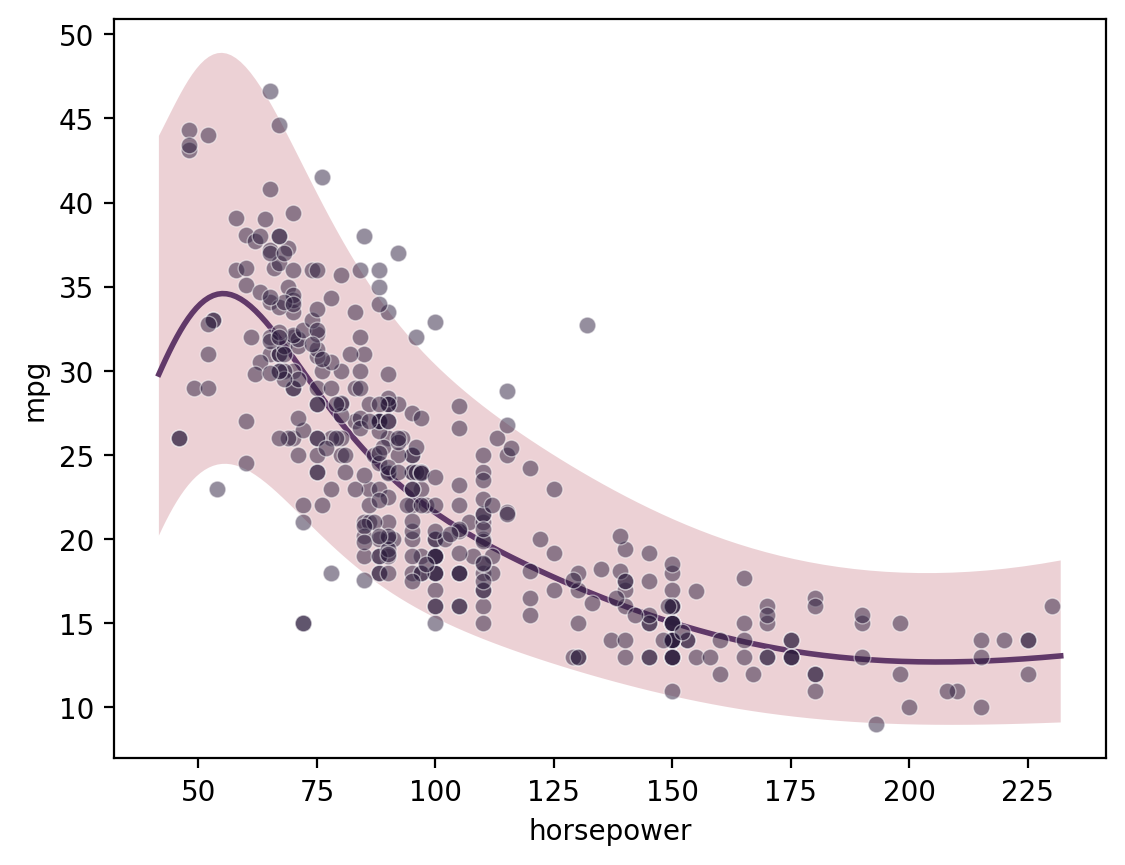

In [4]:
gp = GP(ds)
gp.fit(outputs=['mpg'], continuous_dims=['horsepower'], continuous_kernel='RBF', seed=0, ARD=True)

X = gp.prepare_grid()
y = gp.predict_grid();

pp = gmb.ParrayPlotter(X, y)
pp.plot()
sns.scatterplot(data=cars, x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.5);

/home/john/mambaforge/envs/botorch/lib/python3.12/site-packages/botorch/optim/optimize.py:564: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


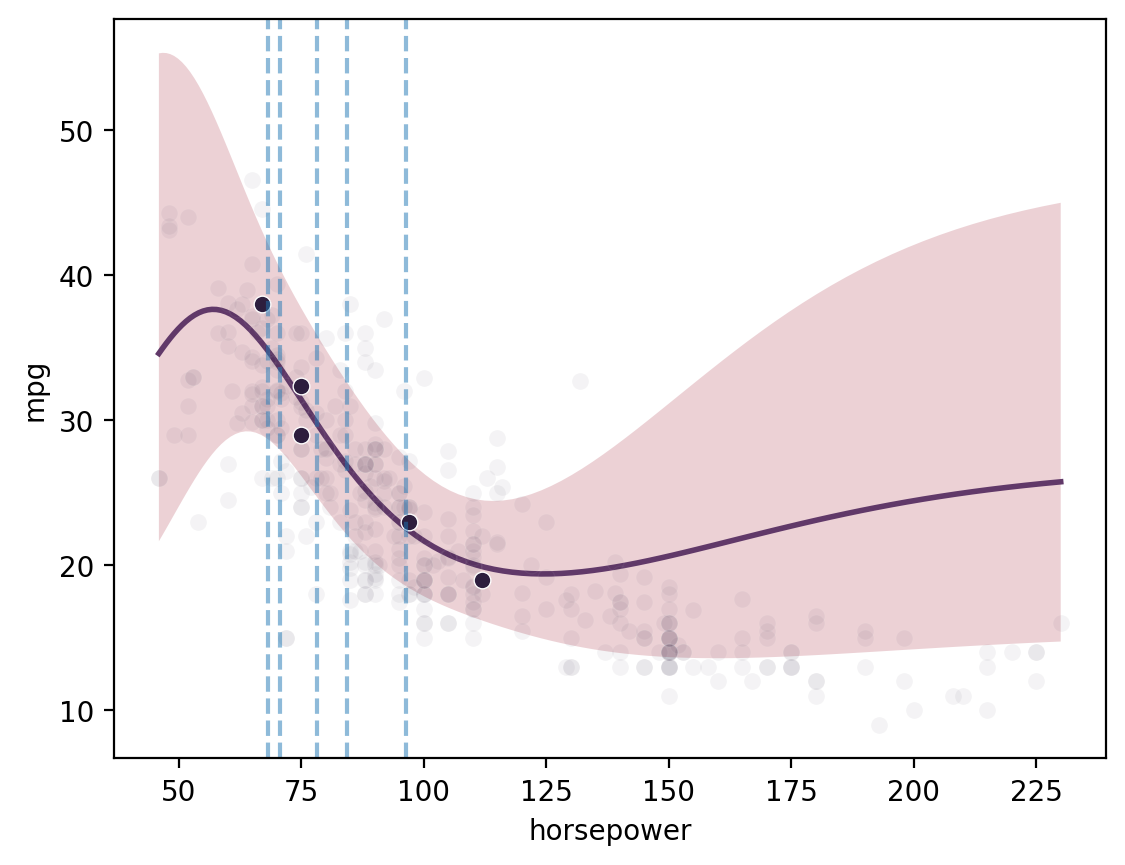

In [5]:
ds2 = gmb.DataSet(
    cars.sample(5, random_state=1),
    outputs=["mpg", "acceleration"],
    log_vars=["mpg", "acceleration", "weight", "horsepower", "displacement"],
)

gp = GP(ds2)
gp.fit(
    outputs=["mpg"],
    continuous_dims=["horsepower"],
    continuous_kernel="RBF",
    seed=0,
    ARD=True,
)

X = gp.prepare_grid(
    limits=gmb.parray(
        horsepower=[ds.wide.horsepower.min(), ds.wide.horsepower.max()], stdzr=gp.stdzr
    )
)
y = gp.predict_grid()

sns.scatterplot(data=cars, x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.05);
pp = gmb.ParrayPlotter(X, y)
pp.plot()
sns.scatterplot(
    data=ds2.wide, x="horsepower", y="mpg", color=sns.cubehelix_palette()[-1]
)

bounds = np.array([[X.z.values().min(0), X.z.values().max(0)]]).T
bounds = torch.from_numpy(bounds).to(gp.device)

candidates, _ = gp.propose(maximize=True, q=5)

for x in candidates:
    plt.axvline(x.values(), color='C0', linestyle='--', alpha=0.5)

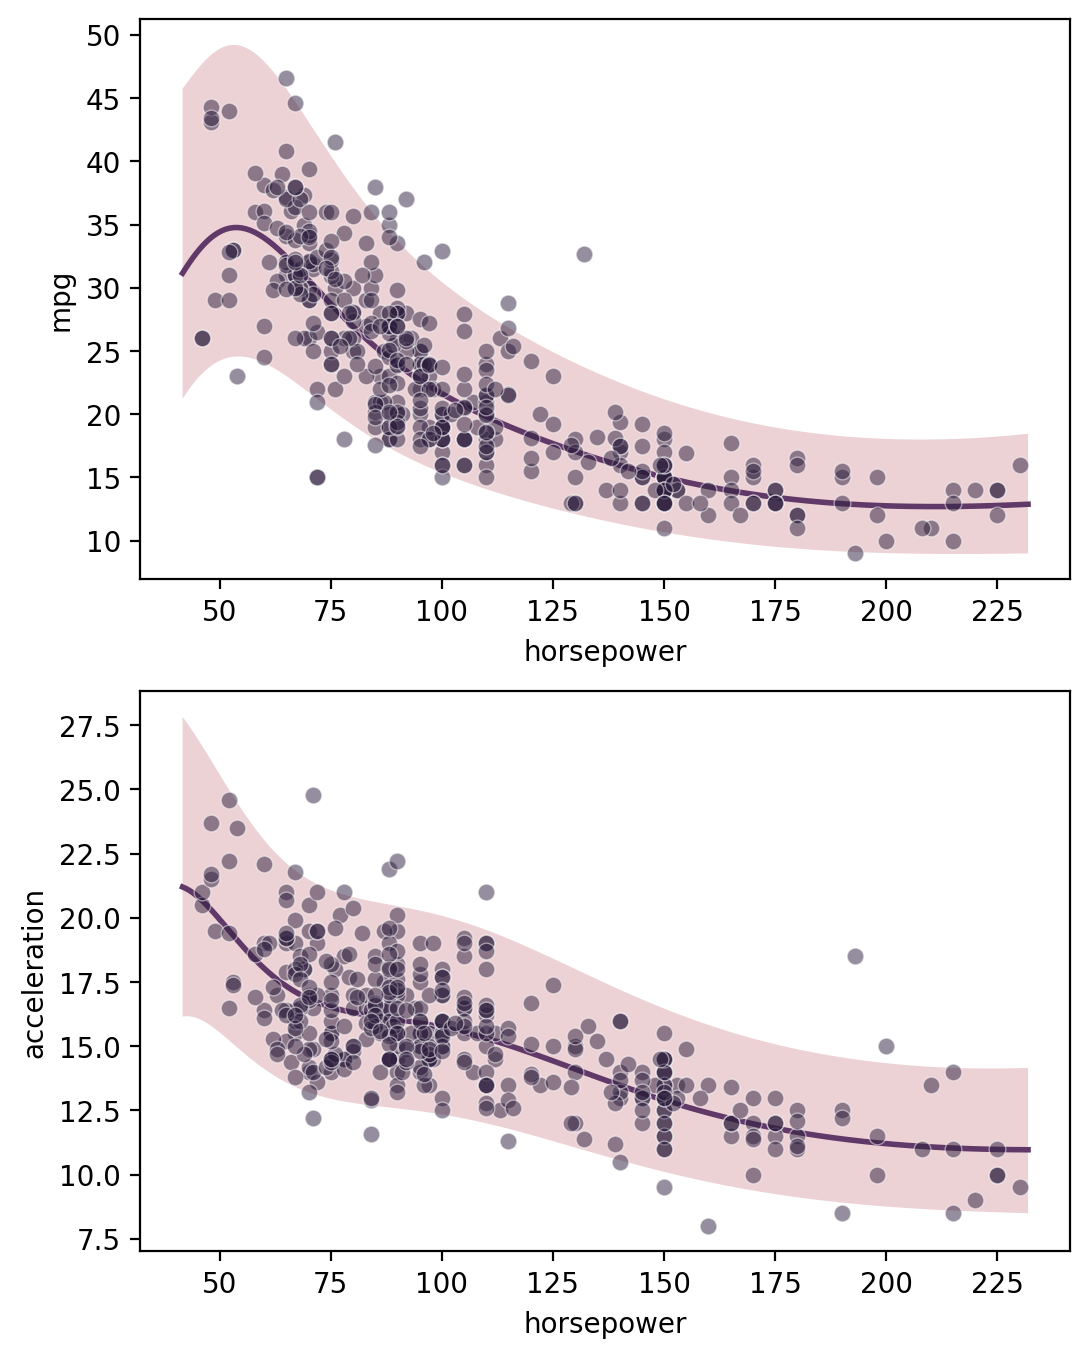

In [35]:
gp = GP(ds)
gp.fit(outputs=['mpg', 'acceleration'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
Y = gp.predict_grid()

axs = plt.subplots(2,1, figsize=(6, 8))[1]
for ax, output in zip(axs, gp.outputs):
    y = Y.get(output)

    gmb.ParrayPlotter(X, y).plot(ax=ax)

    sns.scatterplot(data=cars, x='horsepower', y=output, color=sns.cubehelix_palette()[-1], alpha=0.5, ax=ax);

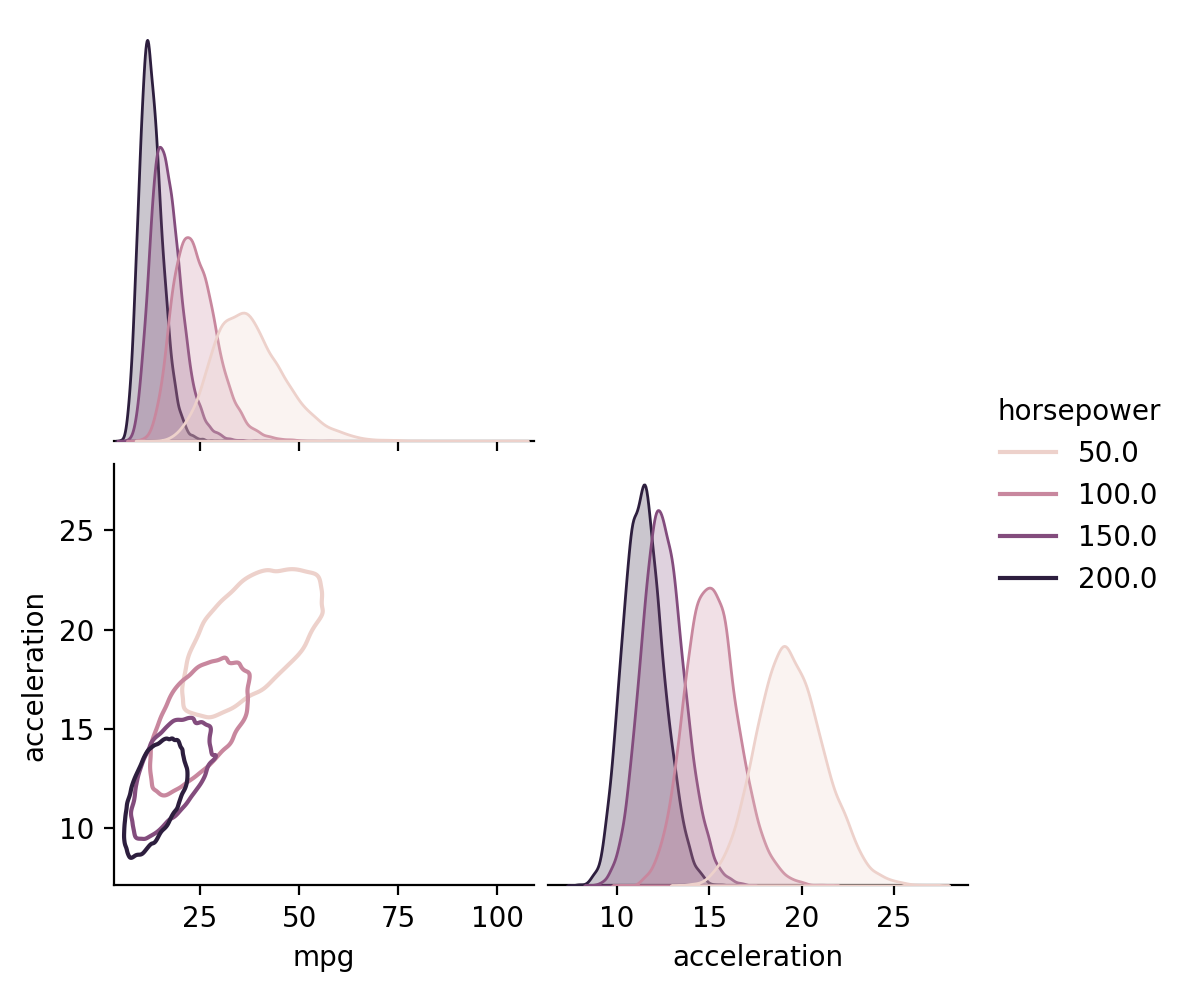

In [7]:
X = gp.parray(horsepower=[50, 100, 150, 200])
gp.predict_points(X)
y = gp.predictions

samples_df = pd.concat(
    [
        pd.DataFrame(point.dist.rvs(10000, random_state=j).as_dict()).assign(
            horsepower=hp.values()
        )
        for j, (point, hp) in enumerate(zip(y, X))
    ],
    ignore_index=True,
)

sns.pairplot(
    samples_df, hue="horsepower", kind="kde", corner=True, plot_kws={"levels": 1}
)

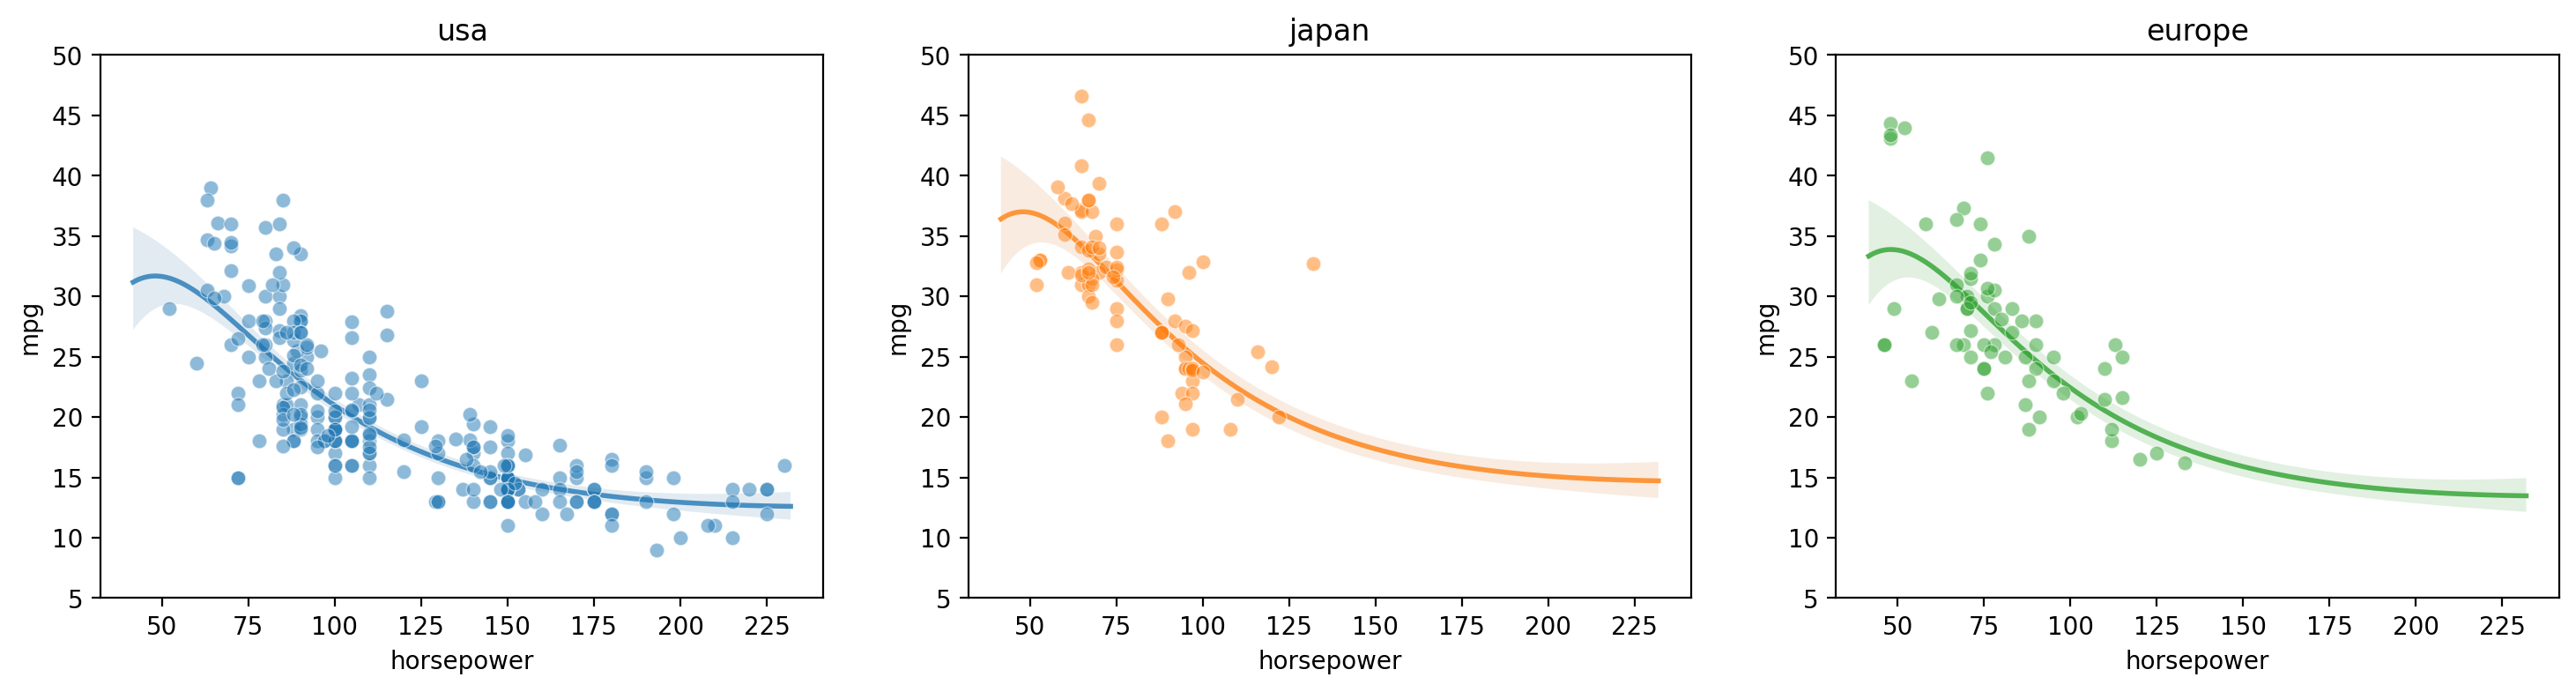

In [16]:
gp = GP(ds)
gp.fit(outputs=['mpg'], categorical_dims=['origin'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
axs = plt.subplots(1,3, figsize=(18, 4))[1]
for i, (ax, origin) in enumerate(zip(axs, cars.origin.unique())):
    y = gp.predict_grid(categorical_levels={'origin': origin}, with_noise=False)

    gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))

    sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y='mpg', color=f'C{i}', alpha=0.5, ax=ax);
    ax.set_title(origin)
    ax.set_ylim([5, 50])

In [35]:
# gp = GP(ds)
# gp.fit(outputs=['mpg', 'acceleration'], categorical_dims=['origin'], continuous_dims=['horsepower'], linear_dims=['horsepower']);

# X = gp.prepare_grid()
# axs = plt.subplots(2,3, figsize=(18, 8))[1]
# for i, (row, origin) in enumerate(zip(axs.T, cars.origin.unique())):
#     Y = gp.predict_grid(categorical_levels={'origin': origin})
#     for ax, output in zip(row, gp.outputs):
#         y = Y.get(output)

#         gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))

#         sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y=output, color=f'C{i}', alpha=0.5, ax=ax);

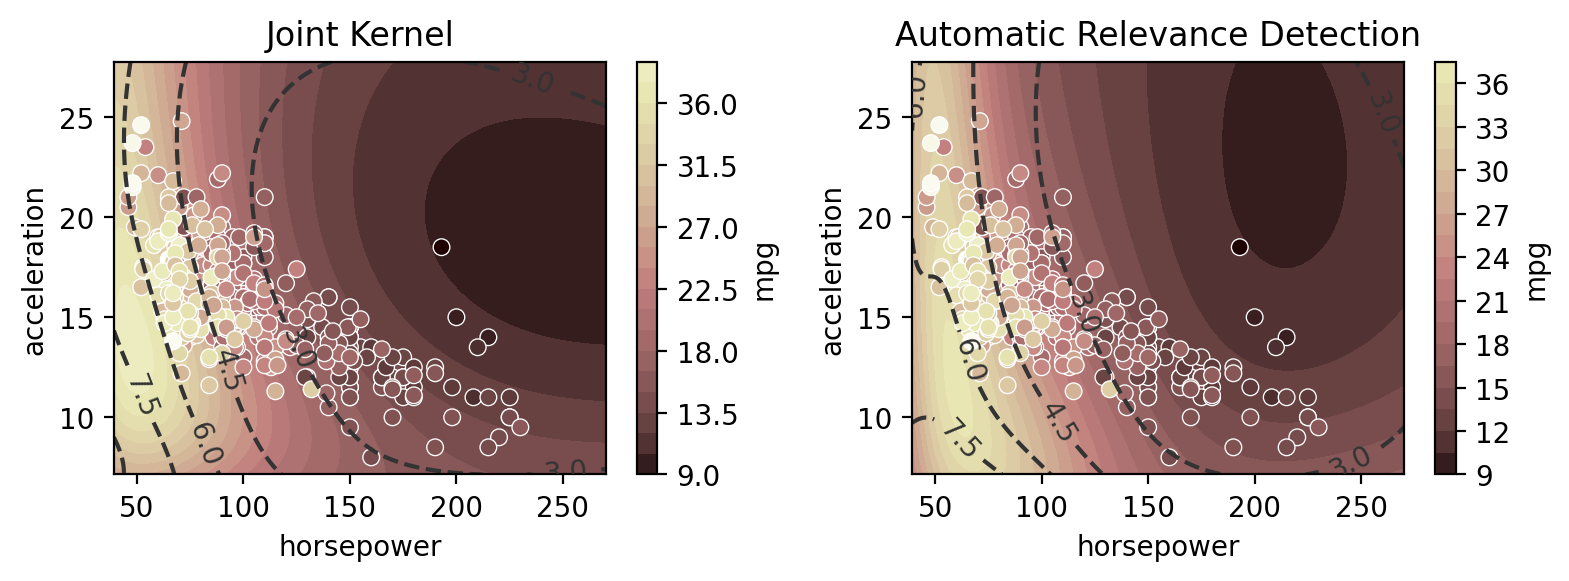

In [17]:
from matplotlib.colors import Normalize as cNormalize
norm = cNormalize()
norm(ds.wide.mpg);

ds3 = gmb.DataSet(
    cars,
    outputs=["mpg"],
    log_vars=["mpg", "acceleration", "weight", "horsepower", "displacement"],
)

gp = GP(ds3)

axs = plt.subplots(1, 2, figsize=(8, 3))[1]
for ax, ard in zip(axs, [False, True]):

    gp.fit(outputs=["mpg"], continuous_dims=["horsepower", "acceleration"], ARD=ard)

    self = gp
    limit_dims = set(self.continuous_dims)
    X, _ = gp.get_structured_data("mean")

    default_values = np.stack(
    [np.minimum(X.z.values().min(1), -2.), np.maximum(X.z.values().max(1), 2.)]
    ).T
    
    padding = np.diff(default_values, axis=1) * 0.1
    
    default_values += np.concatenate([-padding, padding], axis=1)
    
    
    default_parray = self.parray(
        **{
            dim: default
            for dim, default in zip(self.dims, default_values)
            if dim in limit_dims
        },
        stdzd=True
    )

    XY = gp.prepare_grid(limits=default_parray)
    X = XY["horsepower"]
    Y = XY["acceleration"]
    z = gp.predict_grid()
    μ = z.μ
    σ = z.dist.std()

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap="pink", norm=norm)
    pp.colorbar(ax=ax)

    cs = ax.contour(
        X.values(), Y.values(), σ, levels=4, colors="0.2", linestyles="--"
    )
    ax.clabel(cs)

    sns.scatterplot(
        data=cars,
        x="horsepower",
        y="acceleration",
        hue="mpg",
        palette="pink",
        hue_norm=norm,
        ax=ax,
    )
    ax.legend().remove()

    title = "Automatic Relevance Detection" if ard else "Joint Kernel"
    ax.set_title(title)

plt.tight_layout()

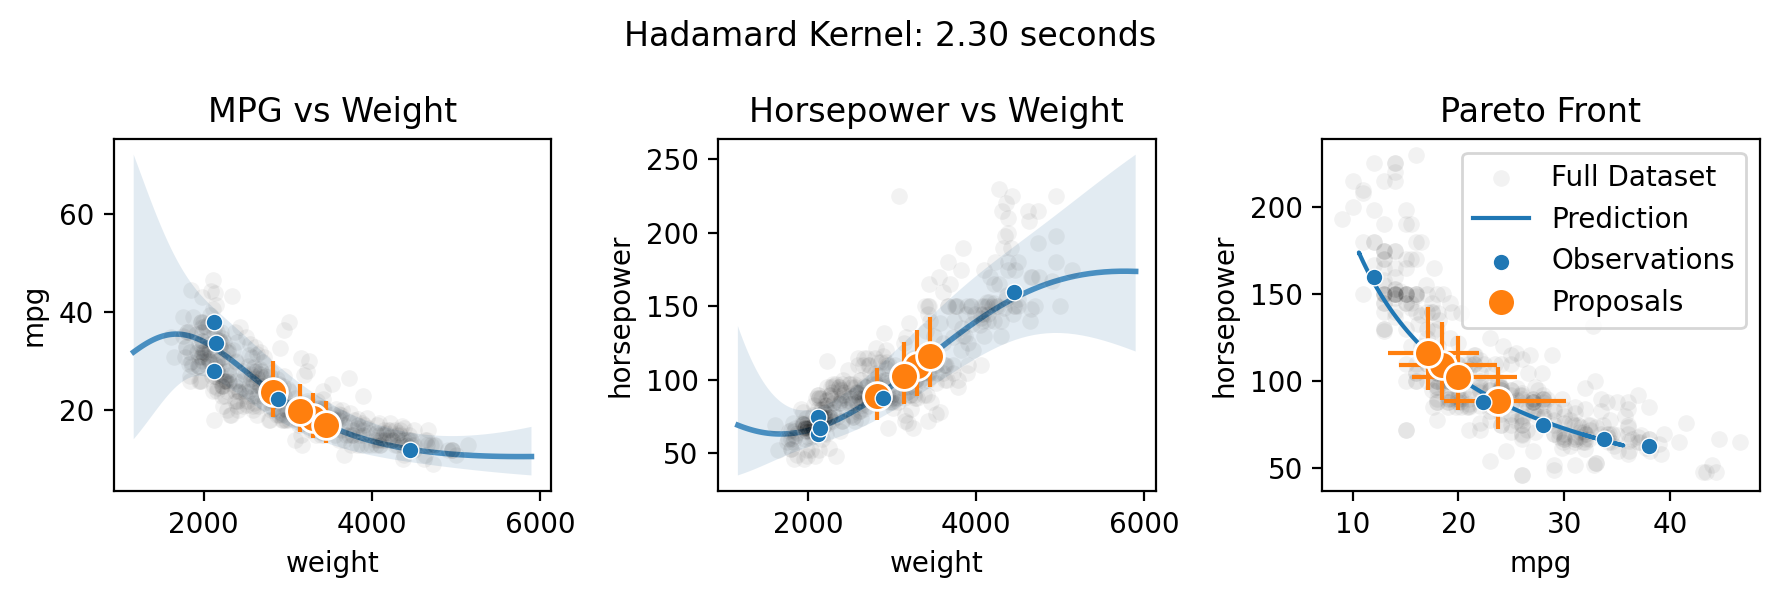

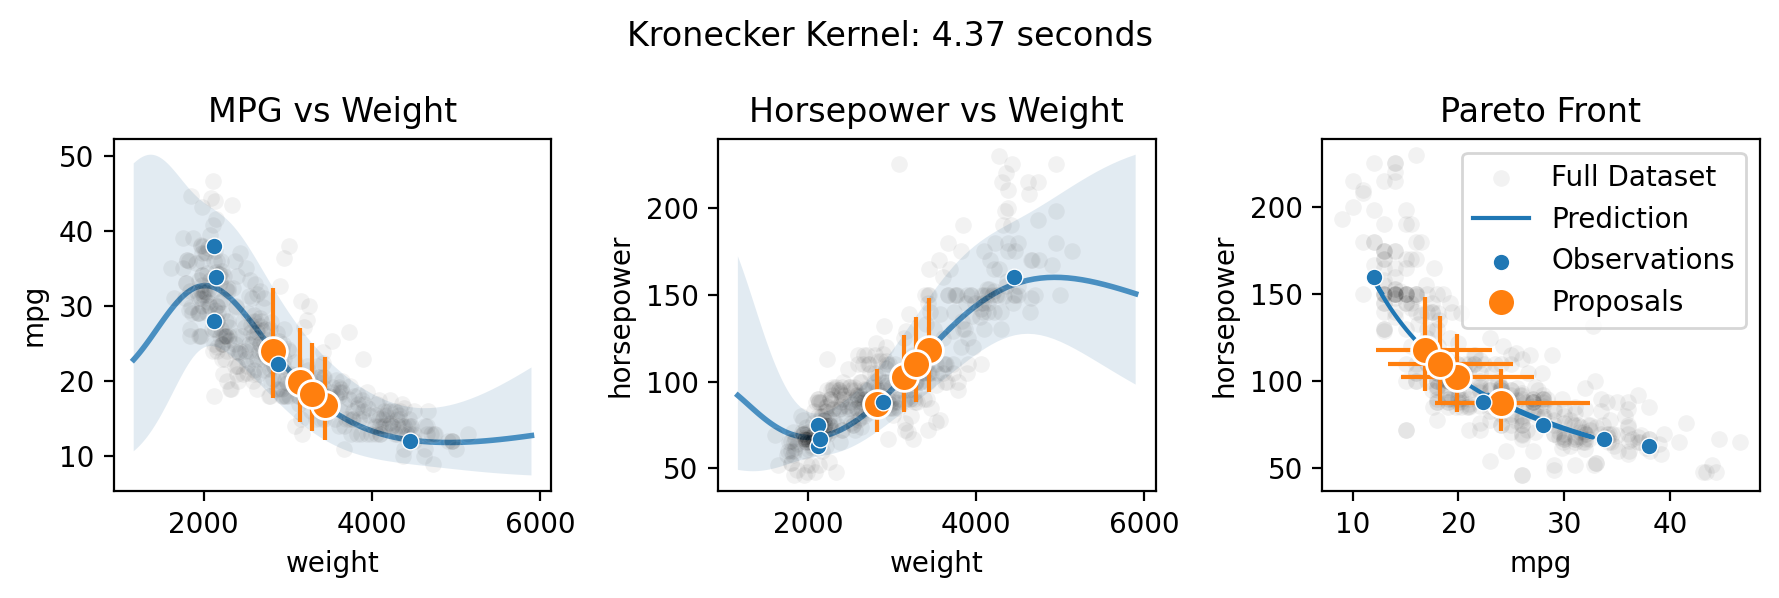

In [64]:
import time
q = 4

ds4 = gmb.DataSet(
    cars.sample(5, random_state=0),
                 outputs=['mpg', 'horsepower','acceleration','displacement','model_year'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

gp = GP(ds4)

for multitask_kernel in ['Hadamard', 'Kronecker']:

    start = time.time()
    gp.fit(outputs=['mpg','horsepower'], continuous_dims=['weight'], continuous_kernel='RBF', seed=0, ARD=True, multitask_kernel=multitask_kernel)

    candidates, _ = gp.propose(q=q)
    preds = gp.predict_points(candidates)

    X = gp.prepare_grid()
    Y = gp.predict_grid()
    end = time.time()

    axs = plt.subplots(1, 3, figsize=(9, 3))[1]
    for ax, output in zip(axs, gp.outputs):
        y = Y.get(output)
        
        sns.scatterplot(data=cars, x='weight', y=output, color='k', alpha=0.05, ax=ax);

        gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette('C0'))
        
        for weight, pred in zip(candidates, preds):
            y = pred.get(output).μ
            y_err = np.abs(np.array([pred.get(output).dist.interval(0.95)]) - y).T
            ax.errorbar(weight, y, y_err, fmt='o', color='C1', ms=10, mec='w')

        sns.scatterplot(data=ds4.wide, x='weight', y=output, color='C0', ax=ax, zorder=10);
        
    ax = axs[2]
    sns.scatterplot(data=cars, x='mpg', y='horsepower', ax=ax, color='k', alpha=0.05, label='Full Dataset')
    ax.plot(Y.get('mpg').μ, Y.get('horsepower').μ, label = 'Prediction', color='C0')

    x = preds.get('mpg').μ
    y = preds.get('horsepower').μ
    x_err = np.abs(np.array(preds.get('mpg').dist.interval(0.95)) - x)
    y_err = np.abs(np.array(preds.get('horsepower').dist.interval(0.95)) - y)
    ax.errorbar(x, y, y_err, x_err, fmt='o', color='C1', ms=10, label='Proposals', mec='w')

    sns.scatterplot(data=ds4.wide, x='mpg', y='horsepower', ax=ax, label='Observations', color='C0', zorder=10)
    ax.legend()

    axs[0].set_title('MPG vs Weight')
    axs[1].set_title('Horsepower vs Weight')
    axs[2].set_title('Pareto Front')
    plt.suptitle(f'{multitask_kernel} Kernel: {end-start:.2f} seconds')
    plt.tight_layout()

In [226]:
cols = ['mpg', 'acceleration', 'weight', 'horsepower']
by_quantile = cars[cols].assign(Quantile=pd.qcut(cars.horsepower, 10, labels=False)).astype({'Quantile': float}).groupby('Quantile')

means = by_quantile.agg('mean').reset_index().melt(id_vars='Quantile', var_name='Variable', value_name='Value').assign(Metric='mean')
yvar = by_quantile.apply(np.log, include_groups = False).reset_index().drop(columns='level_1').groupby('Quantile').agg('var').reset_index().melt(id_vars='Quantile', var_name='Variable', value_name='Value').assign(Metric='var')

stdzr = gmb.Standardizer.from_DataFrame(means.pivot(index='Quantile', columns='Variable', values='Value').reset_index().describe(), log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

ds_agg = gmb.DataSet.from_tidy(pd.concat([means, yvar]).sort_values('Quantile').astype({'Value':float}),
                 outputs=['mpg', 'acceleration'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'],
                 stdzr=stdzr)

/home/john/mambaforge/envs/botorch/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.3037], device='cuda:0', dtype=torch.float64), mean = tensor([3.1065], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


<ErrorbarContainer object of 3 artists>

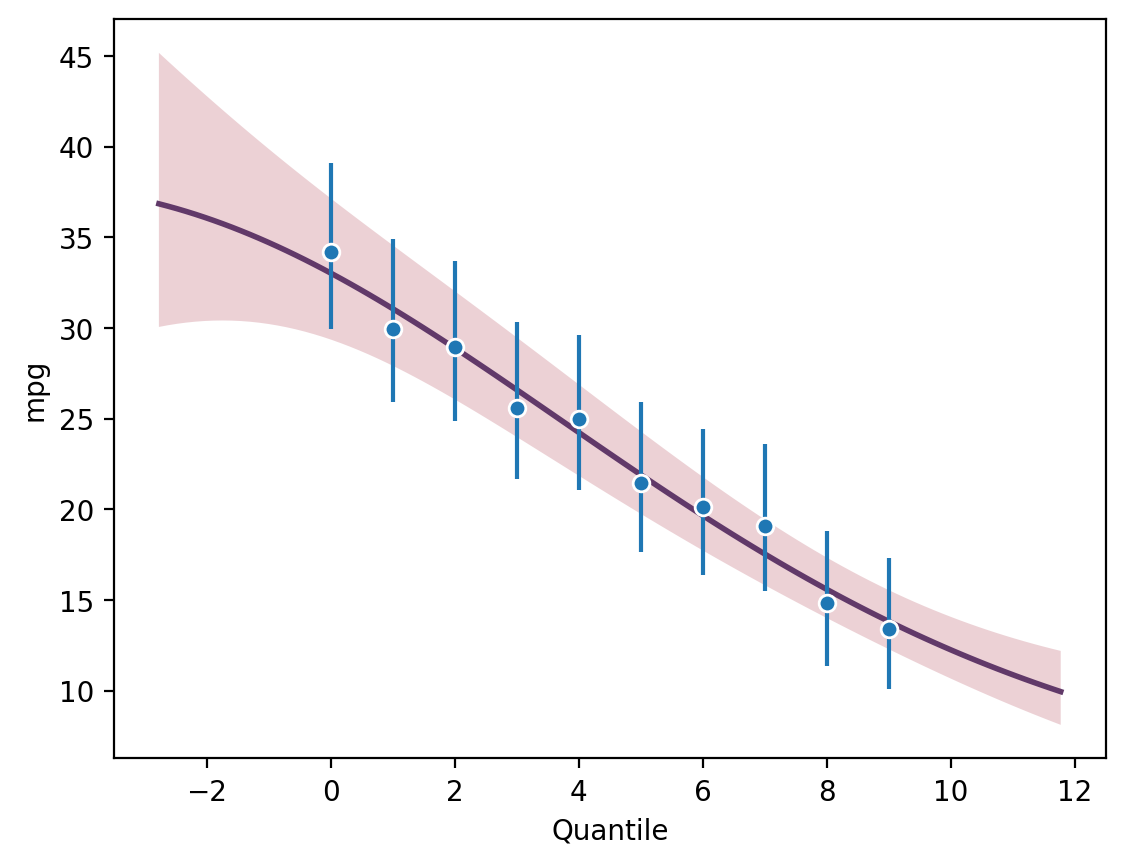

In [205]:
from scipy.stats import lognorm

gp = GP(ds_agg)
gp.fit(outputs=['mpg'], continuous_dims=['Quantile'], continuous_kernel='RBF', seed=0, ARD=True)

X = gp.prepare_grid()
y = gp.predict_grid();

pp = gmb.ParrayPlotter(X, y)
pp.plot()

x = ds_agg.wide.Quantile.unique()
y = ds_agg.wide[ds_agg.wide.Metric=='mean']['mpg']
s = np.sqrt(ds_agg.wide[ds_agg.wide.Metric=='var']['mpg'])
l, u = lognorm(loc=np.log(y), s=s).interval(0.95)
yerr = np.stack([l, u])

plt.errorbar(x, y, yerr, fmt='o', color='C0', mec='w')